# **Notebook for exploring ligand dissociation trajectories of GPCR complexes using pre-computed Protein-Ligand Interaction Fingerprints (IFPs)**

**Aim**: In this tutorial, you will be explore the dissociation pathways of the three systems under investigation starting from pre-computed RAMD trajecotories ([Kokh et al. 2021](https://pubs.acs.org/doi/10.1021/acs.jctc.1c00641)).

**Version**: 1.0 (02.06.2021), 1.1 (06.03.2022) Copyright (c) 2020, Released under the EUPL Licence, v1.2 or any higher version

**Authors/Contributors**: 1.0: Daria Kokh, Rebecca Wade (HITS, Heidelberg, Germany); 1.1 Update: Giulia D'Arrigo, Rebecca Wade (HITS, Heidelberg, Germany)

**Contact**: mcmsoft@h-its.org

**Note**: This notebook has graphical output using nglview. If you use the "RunAll" function of the notebook, this graphical output might not appear on your screen. The cell defined to show the output must be visible in the browser during execution.

**Setting up your environment**

First set up your environment and the needed packages. This might take a while.

In [ ]:
!pip install rdkit-pypi
!pip install MDAnalysis==1.1.1

In [ ]:
#Import python packages needed for the notebook
import glob, os
import sys
import numpy as np
import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
from matplotlib import gridspec
import  pylab as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as clust
from scipy.spatial.distance import pdist

import hashlib
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

**Setting up local directory**

After creating your working directory, you will see it shown on the left panel by clicking on the 'File' icon.

In [ ]:
# Create a local directory
try:
    homeDir = "/content"
except:
    print("Error in environment")

else:
    workDir = os.path.join(homeDir, 'work')
    if not os.path.isdir(workDir):
        try:
            os.mkdir(workDir)
        except:
            print("unable to make working directory")
    
    # Make a new directory to run the use case in. 
    # If directory already exists, add a number to make a unique name
    baseDir = 'tauRAMD-egressroutes'
    dirIter = 0
    useCaseDir = os.path.join(workDir, baseDir)
    pdbdir=os.path.join(useCaseDir,'workshop2022/DATA/PDB')
    
    if os.path.exists(useCaseDir):
        while os.path.exists(useCaseDir):
            dirIter += 1
            useCaseDir = os.path.join(workDir, baseDir + '.' + str(dirIter))            
    
    try:
        os.mkdir(useCaseDir)
        os.chdir(useCaseDir)
    except:
        print("Failed to make use case working directory")
    else:
        print("Working directory for current use case: %s" % useCaseDir)

Working directory for current use case: /content/work/tauRAMD-egressroutes


**Download input files**

Now you will download the files necessary for the analysis of dissociation trajectories (workshop22.zip).

In [ ]:
!wget -O workshop2022.zip https://mcm.h-its.org/wiki/lib/exe/fetch.php?media=googlecolab:workshop2022_2.zip
!unzip -o workshop2022.zip
%cd /content/work/tauRAMD-egressroutes/workshop2022/DATA/
from Scripts.Clustering import *

# **1. Interaction Fingerprint (IFP) generation**

# What is an IFP?  
IFP represents a 3D protein–ligand interaction profile as a binary vector of interactions (such as hydrogen- or halogen-bonds, aromatic stacking, salt bridges, or hydrophobic contacts).

We considered the following 8 classes of receptor–ligand interactions to define the IFPs in the MD-IFP analysis: hydrophobic (**HY**), aromatic (**AR**), hydrogen bond donor (**HD**) or acceptor (**HA**), salt bridge (**IP/IN**), halogen bonds (**HL**), and water bridge (**WB**).

The identification of the protein-ligand interaction fingerprints (PL-**IFPs**) is done using the **RDKit** software and the **MDAnalysis** python library. Prerequisites for the IFP calculation are a structure of a protonated protein–ligand complex and a ligand structure in the mol2 format. For the detection of water bridges, energy minimization of the structure of the protein–ligand complex is desirable. For more details on how IFP is defined, see [Kokh et al. 2019](https://aip.scitation.org/doi/10.1063/5.0019088). Finally, all nonspecific protein–ligand residue contacts (PL-**RE**s) within a threshold of 5 Å between heavy atoms were stored.

The IFPs are computed using the **IFP_generation.py** script (found in `DATA/GPCR-09-2020/Scripts/`) that stores both the PL-IFPs and PL-REs for each snapshot as binary vectors with 0/1 values for each individual contact (*i.e.*, residue and type of interaction). The vectors generated from all trajectories for each compound and for each random force applied are then collected in a binary matrix.

The IFP_generation.py script, besides PL-IFPs and PL-REs, computes the ligand RMSD from the bound position, and the ligand COM for each snapshot and stores them in a `.pkl` file. Below is an example of how .pkl files containing the IFP and COM information should look like:

    AR_PHE162 AR_PHE177 AR_PHE232 AR_TRP137  ... WB_VAL77  COM_x  COM_y  COM_z
    0      0         0         0        0   ...        0  46.00  71.09  85.83
    1      0         0         0        0   ...        0  46.28  71.29  85.7
    2      0         0         0        0   ...        0  46.07  71.13  85.88
    ...   ...        ...       ...      ...  ...      ...   ...    ...    ...

Both PL-IFPs and PL-REs are generated for the last 700 frames of
each RAMD dissociation trajectory, thus discarding most of the frames in which the ligand retains the bound-state position. 

**Note:** If a dissociation event was not observed because the simulation time allowed was exceeded, the trajectory was discarded from the analysis.


# **2. Read IFP data and prepare them for analysis**


With the next cell we assign variables to the different definitions of IFPs (IFP and/or non specific contacts (RE)) and different simulation tyoes (according to the different force magnitude).

In [ ]:
IFP_all =  ["AR","HD","HA","HY","WB","IP","IN","WB"]
IFP_RE =  ["RE"]
IFP_mixed =  ["AR","HD","HA","HY","WB","IP","IN","WB","RE"]

# naming: forse cambiare 600 con 700
# "*SL-600-RAMD*.pkl"  - force 14 kcal/mol A
# "*FA-600-RAMD*.pkl"  - force 16 kcal/mol A
# "*EX-600-RAMD*.pkl"  - force 12 kcal/mol A
# "*SU-600-RAMD*.pkl"  - force 10 kcal/mol A
# "IXO-CHL"   - iperoxo
# "IXO-ALO"   - iperoxo _PAM
# "ACh-CHL"   - Ach

# choose simulation type
simulation_type = {"f16_":"*FA-700-RAMD*.pkl","f14_":"*SL-700-RAMD*.pkl","f12_":"*EX-700-RAMD*.pkl","f10_":"*SU-700-RAMD*.pkl",}

**2.1 Define system and data location to be analyzed**

The working directory `workshop2022/DATA/GPCR-09-2020/` contains all the `*pkl` files necessary for the IFP analysis for all the three ligands (IXO-CHL, IXO-ALO and ACh-CHL) at all the different force magnitudes.

With the following cell, you are first requested to choose the force magnitude (`version`) and the ligand of interest (`ligand`). As a result, a directory for storing the IFP analysis results will be created. IXO-CHL and force magnitude 12 kcal mol-1 Å-1 are selected for the analysis.


In [ ]:
######################## Select the system to be analized
dir_all =  os.path.join(useCaseDir, "workshop2022/DATA/GPCR-09-2020/")

noLIP = False
# Choose a system: either mAChR M2 muscarinic receptor or β2AR - β2-adrenergic receptor 
M2 = True
AR = not M2
# choose data computed using a specific RAMD force 
version = "f12_" 
#############################

DIR_in = dir_all
if M2: 
    # choose a ligand:   
    #   "IXO-ALO" - iperoxo with PAM
    #   "IXO-CHL" - iperoxo
    #   "ACh-CHL" - Ach
    ligand ="IXO-CHL" 
    name_template = ligand+simulation_type[version] #"*SL-700-RAMD*.pkl"  "*FA-700-RAMD*.pkl"
    DIR_out = DIR_in+ligand+"-Results/"
    if not os.path.exists(DIR_out): os.mkdir(DIR_out)
elif AR:
    ligand =  "b2AR" 
    name_template = ligand+simulation_type[version]   #"*EX-700-RAMD*.pkl"  "*SL-700-RAMD*.pkl"  "*FA-600-RAMD*.pkl"
    DIR_out = DIR_in+ligand+"-Results/"
    if not os.path.exists(DIR_out): os.mkdir(DIR_out)
print(DIR_out)

/content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-Results/


**2.2 Read IFP database for just one ligand**

With the following cell all the IFP `.pkl` files for the chosen ligand and the chosen force magnitude are read and concatenated into the `df_tot` dataset. The resulting dataset is then sorted by residue number and IFP type.

In [ ]:
#---- read IFP data set: 
df_tot_org,ligandsi,directi = read_databases(DIR_in,name_template,name_len =50)
#print(df_tot_org.shape)  
if df_tot_org.shape[0] == 0:
    print(" Files were not found !!!")
    sys.exit()
    
#---- sort residues by number
resi_list_sorted,resi_name_list_sorted,ifp_list = separate_IFP(df_tot_org.columns.tolist())

try:
    if(np.unique(df_tot_org.Repl.values) == ''):
        Repl = []
        R = 0
        start = np.argwhere(df_tot_org.time.values == 0).flatten()
        for i in range(0,df_tot_org.shape[0]): 
            if i in start: R += 1
            Repl.append("Repl_"+str(R))
        df_tot_org.Repl = Repl
except:
    pass

File:  /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-RAMD_5.pkl
----------  Name:  IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-
Trajectory length will be taken from /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-RAMD_5.dat
!!!  Number of trajectories in pkl and dat files are different! -  /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-RAMD_5.pkl
File:  /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-RAMD_6.pkl
----------  Name:  IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-
Trajectory length will be taken from /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-2020/IXO-CHL-lipid14-fixed-cleanBS-unwtapped-WB-EX-700-RAMD_6.dat
File:  /content/work/tauRAMD-egressroutes/workshop2022/DATA/GPCR-09-20

**2.3 Check ligand RMSD and dissociation through the membrane**


1.   With the following cell, the protein and ligand RMSD at the beginning and at the end of the simulation are checked in order to discard trajectories where the ligand RMSD is too small at the end of the simulation or the protein RMSD is too large.
2.   Then the interactions with lipids are verified in order to compute the number of dissociation trajectories going through the membrane. The egress routes through the membrane are defined as follows:
   - first frame  where less than 2 non-specific ligand-protein contacts are found.
   - if the ligand has contacts with more than 3 lipids in the first frame as the ligand leaves the protein.






This is done iteratively for all the RAMD trajectories of each replica.

(14,)
    too large protein RMSD (to be discarded):  18.111272996288413
    too large protein RMSD (to be discarded):  18.45889359797654
    too large protein RMSD (to be discarded):  16.085509563076634
0  LIPID interaction:  Repl_37 3  Lip sum: 13 Wat sum:  185 Lip max contacts:  6.0
    too small ligand RMSD at the end (to be discarded):  1.3466740864968292 1.4249915358608247
    too large protein RMSD (to be discarded):  36.90150023583909
    too small ligand RMSD at the end (to be discarded):  1.7700873709081224 1.8804283875506236
    too small ligand RMSD at the end (to be discarded):  1.735497230174002 1.7859223804335091
    too small ligand RMSD at the end (to be discarded):  1.3042732779448318 1.6852951992818281
    too small ligand RMSD at the end (to be discarded):  1.2383288962681473 1.3757881746206146
    too small ligand RMSD at the end (to be discarded):  1.3271089881711713 2.2631691751666634
    too small ligand RMSD at the end (to be discarded):  0.8282399735337207 0.72

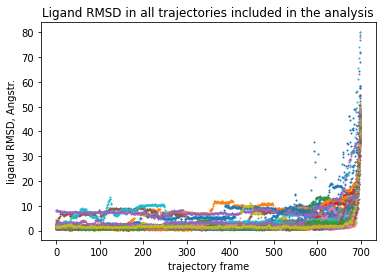

Traj to be discarded:  15 from  70
 trajectories now: 55


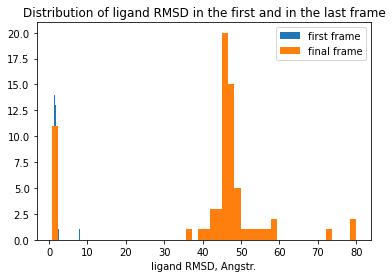

================ Summary=====================
rough estimation of tau =  29.129804486089718 1.9888886443214626 701.0 70
Egress into membrane (number of traj):  1 ( 1.4 %)


(414, 45)

In [ ]:
print(np.unique(df_tot_org.Traj.values.astype(int)).shape)
threshold_start_RMSD = 15
threshold_end_RMSD = 15
threshold_protein_RMSD = 10
lipid_interaction = 15

trj_to_discard = []
start_RMSD = []
end_RMSD = []
times = []
#tot_traj1 = 0
tot_traj = 0
k = 0

LIP_list = [r for r in df_tot_org.columns.values 
            if (r[:5] in ['RE_CH','RE_OL','RE_PA','RE_PE','RE_PC']) or  r.find('RE_PH-') >=0]
RE_list = [r for r in df_tot_org.columns.values 
            if ( not (r in LIP_list)  and r.find('RE_') >=0 )]
CHL_list = [r for r in df_tot_org.columns.values 
            if (r[:5] in ['RE_CH'])]

# loop over replicas
Lip_egress = 0
for j in np.unique(df_tot_org.Repl.values):
    df_tot_Repl = df_tot_org[df_tot_org.Repl == j]
    # loop over trajectories
    for i in np.unique(df_tot_Repl.Traj.values.astype(int)):
        tot_traj +=1
        df_tot_Repl_Traj = df_tot_Repl[df_tot_Repl.Traj == str(i)]
        start_RMSD.append(df_tot_Repl_Traj.RMSDl.values[0])
        end_RMSD.append(df_tot_Repl_Traj.RMSDl.values[-1])
        try:
            times.append(np.unique(df_tot_Repl_Traj.length.values)[0])
        except:
            print("ERROR---------------------------")
            print(np.unique(df_tot_Repl_Traj.length.values)[0])
        if(df_tot_Repl_Traj.RMSDl.values[0] > threshold_start_RMSD) :
            print("    too large ligand RMSD in the first frame : ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        elif (df_tot_Repl_Traj.RMSDl.values[-1] < threshold_end_RMSD) :  
            trj_to_discard.append((j,i))
            print("    too small ligand RMSD at the end (to be discarded): ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
            continue
        elif (df_tot_Repl_Traj.RMSDp.max() > threshold_protein_RMSD) :  
            trj_to_discard.append((j,i))
            print("    too large protein RMSD (to be discarded): ",df_tot_Repl_Traj.RMSDp.max())
            #continue
        elif "LIP" in  df_tot_Repl_Traj.columns.values:
            # select  frames where less than 2 non-scpecific ligand-protein contact found
            df_tot_diss = df_tot_Repl_Traj[df_tot_Repl_Traj[RE_list].sum(axis=1) < 1 ] 
            #  select frames  where lipids  contact with the ligand
            LIP_contacts = df_tot_diss[LIP_list].sum(axis=1).values 
            # only if ligand has contacts with more than 3 lipid in the first frame as ligand left the protein
            if len(LIP_contacts) > 0:
                if LIP_contacts[0] > 3 and len(LIP_contacts[LIP_contacts > 0]) > 1: 
                    print(k," LIPID interaction: ",j,i," Lip sum:",df_tot_diss.LIP.values[-20:].sum(),
                      "Wat sum: ",df_tot_diss.WAT.values[-20:].sum(),"Lip max contacts: ",np.max(LIP_contacts))
                    Lip_egress += 1
                    if noLIP: 
                        trj_to_discard.append((j,i))
                        k += 1
                        continue
        plt.plot(df_tot_Repl_Traj.RMSDl,marker='o', linestyle="",markersize=1)

plt.ylabel("ligand RMSD, Angstr.",fontsize=10)
plt.xlabel("trajectory frame",fontsize=10)
plt.title("Ligand RMSD in all trajectories included in the analysis")
plt.show()
print("Traj to be discarded: ", len(trj_to_discard), "from ",tot_traj)
#print("Original data size: ",df_tot_org.shape)
for j,i in trj_to_discard:
#    print("To discard:",i,j)
    df_tot_org = df_tot_org[~((df_tot_org.Traj == str(i)) & (df_tot_org.Repl == j))]
#print("Final data size: ",df_tot_org.shape)
print(" trajectories now:",df_tot_org[df_tot_org.time == 0].shape[0])

plt.hist(start_RMSD,bins=50, label= "first frame")
plt.hist(end_RMSD,bins=50, label= "final frame")
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.legend(fontsize = 10)
plt.title("Distribution of ligand RMSD in the first and in the last frame")
plt.show()

bt2 = bootstrapp(times, rounds=50000)
mu, std = norm.fit(bt2)
print("================ Summary=====================")
print("rough estimation of tau = ",mu,std,max(times),len(times))
print("Egress into membrane (number of traj): ",  Lip_egress,"(",np.round(100*Lip_egress/tot_traj,1),"%)")
df_tot_org[LIP_list].loc[(df_tot_org[LIP_list]!=0).any(1)].shape

# **3. Finding dissociation pathways and metastable states using kmeans clustering**

**3.1 Change residue numbering and extract a list of columns that corresponds to IFP only or any contacts(IFP_RE)**

The next cell is needed to renumber the residues according to the crystal structure numbering to ease the analysis and interpretation. As a result, a new list with the renumbered IFPs will be produced.

In [ ]:
# --- Select IFP only-
ifp_all_list = IFP_all

ifp_list = IFP_RE  # will do clustering on unspecific contacts 

# we will re-number residues to X-ray numbering a for convenience and select only contacts from the ifp_list
shift = 0
columns_IFP = []
columns_IFP_all = []
columns_IFP_renamed = {}
for c in df_tot_org.columns.values:
    if c in LIP_list: continue  # we will not use ligand-lipid contacts for clustering
    if c[0:2] in IFP_mixed :   
        if M2:
            if int(c[6:]) < 215: shift = 18
            else:     shift= 164 
        elif AR:
            if int(c[6:]) < 200: shift = 31
            elif int(c[6:]) < 360: shift = 800
            else: shift = -97
        if c[0:2] in ifp_list: 
            columns_IFP.append(c[:6]+str(int(c[6:])+shift))
        if c[0:2] in ifp_all_list: 
            columns_IFP_all.append(c[:6]+str(int(c[6:])+shift))
        columns_IFP_renamed.update( {c : c[:6]+str(int(c[6:])+shift)} )
df_tot = df_tot_org.rename(columns_IFP_renamed, axis='columns')

**3.2 Re-organize the  IFP dataframe df_ext and prepare IFP matrix Xt for clustering**

In the next cell, a matrix `Xt` containing the IFP_RE (nonspecific contacts will be used for clustering) will be generated. 

In [ ]:
unpickled_df=df_tot        

#remove rare contacts
df_ext_tmp = unpickled_df[columns_IFP]        
#print("Original ", df_ext_tmp.shape)
columns_IFP_reduced = np.asarray(columns_IFP)[df_ext_tmp.sum(axis=0).values > 0]
df_ext = df_ext_tmp[columns_IFP_reduced]   
columns_IFP = columns_IFP_reduced
#print("Reduced", df_ext_tmp.shape)
        
X = df_ext_tmp.values
    
#print(X.shape)
if "Auxi_2" in unpickled_df.columns: # column Auxi-2 containes RMSD of the PAM
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM","Auxi_2" ]
elif "WAT" in unpickled_df.columns: # add water analysis if it is included in the DataFrame
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM"]
else:
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","RGyr","COM_x","COM_y","COM_z","COM"]
df_ext[add_columns] = unpickled_df[add_columns]

#count = df_tot_org[columns_IFP_renamed].sum(axis=1).values
#count = count.reshape(count.shape[0],1)
# Xt(i,j) is a numpy matrix containing IFPs (j) for all frammes (i) that well be used fro clustering
Xt = X #np.concatenate((X,10*count/np.amax(count)),axis =1)

**3.3  Clustering**

With the following cell, we are going to perform the clustering of the IFP_RE matrix `Xt`. We employ k-means clustering using the `scikit-learn` package with default parameters.

**Important Note:** The scikit-learn version used in this tutorial is the latest (v. [`1.0.2`](https://scikit-learn.org/stable/whats_new/v1.0.html)), and is different from the one used in [Kokh et al. 2021](https://pubs.acs.org/doi/10.1021/acs.jctc.1c00641) (v. `0.22.1`) . This leads to small changes in the visualization of the clustering. Choosing different seeds for the clustering also results in small differences in the clustering.

**Also note** that different clustering methods can be used.

To decide the number of clusters to generate, we employed the `Silhouette` method and selected 10 clusters, which is a compromise considering the high variation of Silhouette plots for the systems studied (as shown in Fig. S2 of [Kokh et al. 2021](https://pubs.acs.org/doi/10.1021/acs.jctc.1c00641)). 



In [ ]:
# different clustering procedures can be used
#from kmodes.kmodes import KModes
kmodes = False #to use kmode, one has to instal KModes package and uncomment line above

GM  = False
Optics = False
Frame_clusters = 10

if GM: 
    from sklearn import mixture
    gmm = mixture.GaussianMixture(n_components=Frame_clusters, covariance_type='full').fit(Xt)
    labels_ = gmm.predict(Xt)
elif kmodes:
    km = KModes(n_clusters=Frame_clusters, init='Huang', n_init=2, verbose=0).fit_predict(Xt) 
    labels_ = km.labels_
elif Optics:
    from sklearn.cluster import OPTICS
    km = OPTICS(min_samples=2).fit(Xt)
    labels_ = km.labels_
else:
    km = KMeans(n_clusters=Frame_clusters, algorithm ="full" , random_state=0).fit(Xt)
    labels_list = np.unique(km.labels_)
    labels_ = km.labels_

labels_rename = labels_

# we will rename labels to make another  position of the cluster plot (to put clusters more distantly) 
# this is needed to exactly reproduce plots from the paper, otherwise, it is not nessesary
if AR:
    #
    labels_rename = []
    for l in labels_:
        if l == 4: labels_rename.append(7)
        elif l == 7:  labels_rename.append(4)
        else: labels_rename.append(l)
elif M2 and ( version == "f12_")  :
    labels_rename = []
    for l in labels_:
        if ligand == "IXO-CHL" :
            if l == 2: labels_rename.append(8)
            elif l == 8:  labels_rename.append(2)
            else: labels_rename.append(l)
        else:
            labels_rename = labels_
else: labels_rename = labels_
    
    
# we add cluster labels to the data frame
df_ext["label"] = labels_rename

#print(df_ext.shape,Xt.shape)

 **3.4 Find and visualize metastable states from clustering (using nonspecific contacts IFP-REs)**

The following cell will dispaly the clustering plot where each cluster is shown by a node with the size indicating the cluster population. Nodes C*i* are positioned on an increasing logarithmic scale of the average ligand COM displacement in the cluster from the starting snapshot, and the node color denotes the averaged ligand RMSD in the cluster from the starting structure (initial bound position). 

The gray arrows indicate the total flow between two nodes [i.e., transitions (C*i* → C*j*) − (C*j* ← C*i*)] with their thickness proportional to the flux magnitude in alignment with the corresponding Flow heatmap.


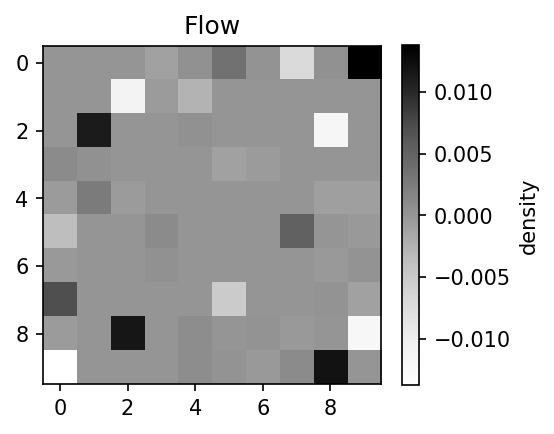

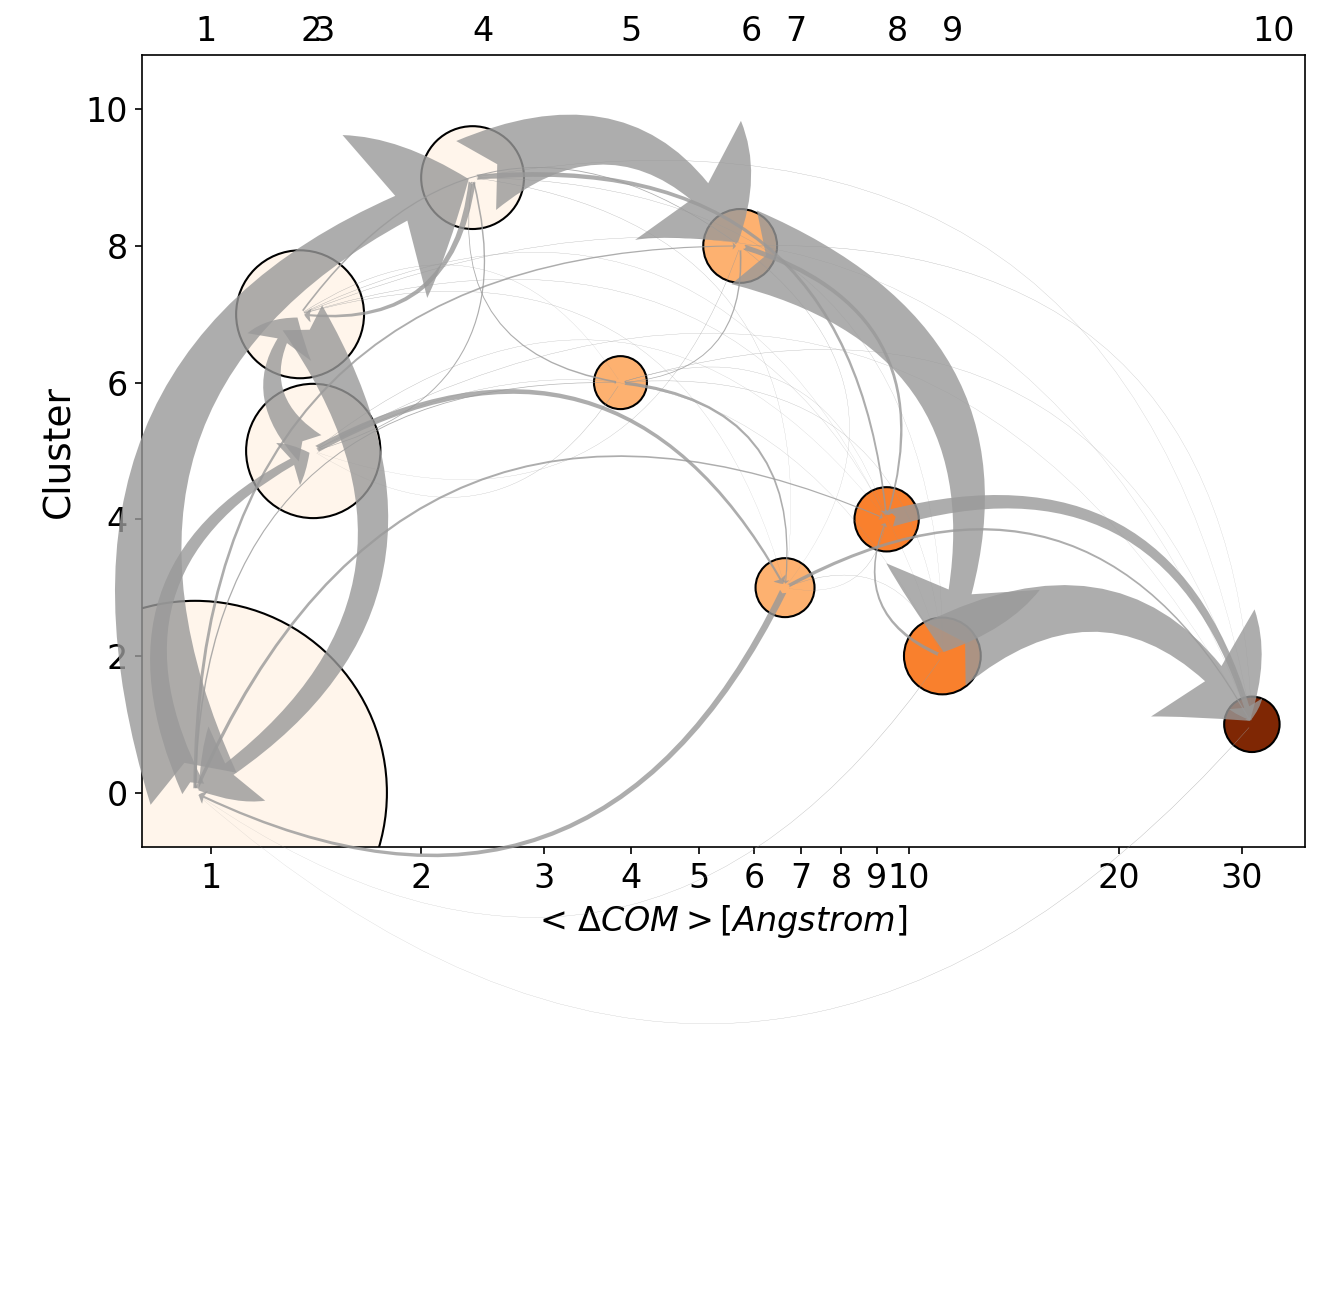

In [ ]:
out_name = "cluster-traj.png"
arg_Label_list = plot_graph_COM_v1(df_ext,DIR_out+out_name,ligand=[],draw_round = False,water=False,edges_show=False,diss_show=False)

**3.5 Cluster components**

**3.5.1 Show IFP contribution to each cluster**

With the following cell, PL-IFPs contribution to each cluster showing the population of specific protein-ligand interactions is computed together with the PL-RE (unspecific contacts) composition. 

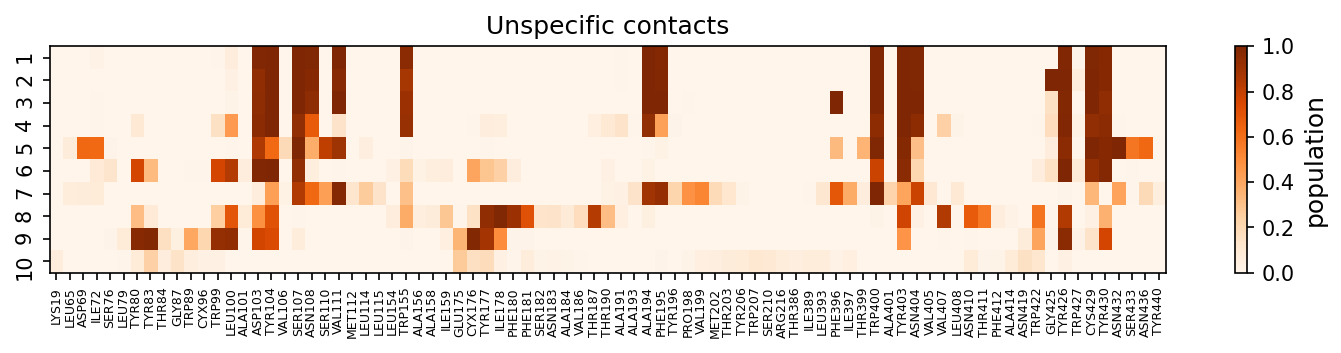

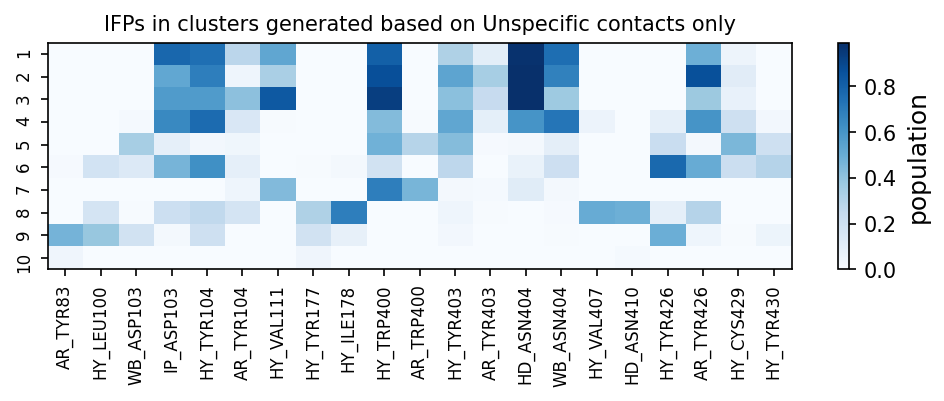

In [ ]:
# threshold used to discard some IFPs (less populated) from the image plot 
threshold = 0.05

sorted_labels = labels_list[arg_Label_list]

file_save = DIR_out+"cluster_traj-population-img.png"
df_ext_ligand = df_ext[df_ext.ligand.isin([ligand])]

p = []
for c in columns_IFP: p.append(c[6:])
indx = np.argsort(np.asarray(p).astype(float))  

p_ifp = []
for c in columns_IFP_all: p_ifp.append(c[6:])
indx_ifp = np.argsort(np.asarray(p_ifp).astype(float))  

ar = np.zeros((len(sorted_labels),indx.shape[0]), dtype = float)
ar_ifp = np.zeros((len(sorted_labels),indx_ifp.shape[0]), dtype = float)
for i,l in enumerate(sorted_labels):
    ar[i] = df_ext[df_ext.label == l][columns_IFP].mean().values[indx]
    ar_ifp[i] = unpickled_df[df_ext.label == l][columns_IFP_all].mean().values[indx_ifp]
    
br = np.max(ar,axis=0)
indx_threshold = np.where(br > threshold)[0]
col_threshold = np.asarray(columns_IFP)[indx][indx_threshold]

RE_col_threshold = []
IFP_col_threshold = []
RE_indx_threshold = []
IFP_indx_threshold = []

for i,c in enumerate(col_threshold):
    if c[:2] == "RE": 
        RE_col_threshold.append(c[3:])
        RE_indx_threshold.append(i)
    else: 
        IFP_col_threshold.append(c)
        IFP_indx_threshold.append(i)
IFP_indx_threshold = np.asarray(IFP_indx_threshold)
IFP_col_threshold = np.asarray(IFP_col_threshold)
RE_col_threshold = np.asarray(RE_col_threshold)
RE_indx_threshol = np.asarray(RE_indx_threshold)


# show IFP composition of the generated clusters
if len(ifp_list) > 1:
    file_save = DIR_out+"cluster_traj-population-IFP-img.png"
    fig = plt.figure(figsize = (12, int(Frame_clusters/4.1)),facecolor='w',dpi=150)
    ax = plt.subplot(1,1,1)
    max_ar = np.amax(ar[:,indx_threshold][:,IFP_indx_threshold])
    ec=plt.imshow(ar[:,indx_threshold][:,IFP_indx_threshold],cmap='Blues',aspect = "auto")
    plt.xticks(range(0,col_threshold[IFP_indx_threshold].shape[0]),col_threshold[IFP_indx_threshold] ,rotation=90,fontsize=6)
    plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=8,rotation=90)
    ax.set_title("IFP ")
    cbar = plt.colorbar(ec)
    cbar.set_label('population',fontsize=12)

    if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
    else: plt.show()

# show unspecific contact contribution is they are included in clustering
if "RE" in ifp_list: 
    fig_l = 10
    if M2 : fig_l = 8
    file_save = DIR_out+"cluster_traj-population-RE-img.png"
    fig = plt.figure(figsize = (12, int(Frame_clusters/5.)),facecolor='w',dpi=150)
    ax = plt.subplot(1,1,1)
    ec=plt.imshow(ar[:,indx_threshold][:,RE_indx_threshold],cmap='Oranges',aspect = "auto")
    plt.xticks(range(0,col_threshold[RE_indx_threshold].shape[0]),RE_col_threshold ,rotation=90,fontsize=6)
    plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=10)
    ax.set_title("Unspecific contacts",fontsize=12)
    cbar = plt.colorbar(ec)
    cbar.set_label('population',fontsize=12)
    
    if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
    else: plt.show()
    if len(ifp_list) == 1:
        threshold_ifp = 0.5
        file_save = DIR_out+"cluster_traj-population-IFP-img.png"
        fig = plt.figure(figsize = (fig_l, int(Frame_clusters/5.)),facecolor='w',dpi=150)
        ax = plt.subplot(1,1,1)
        ec=plt.imshow(ar_ifp[:,np.sum(ar_ifp,axis=0)> threshold_ifp],cmap='Blues',aspect = "auto")
        ax.set_title("IFPs in clusters generated based on Unspecific contacts only",fontsize=10)
        plt.xticks(range(0,np.array(columns_IFP_all)[np.sum(ar_ifp,axis=0)> threshold_ifp].shape[0]),np.array(columns_IFP_all)[indx_ifp][np.sum(ar_ifp,axis=0)> threshold_ifp],rotation=90,fontsize=8)
        plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=8)
        cbar = plt.colorbar(ec)
        cbar.set_label('population',fontsize=12)
        if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
        else: plt.show()

**3.5.2 Save clusters on a 3D grid; use COM of just one ligand**

With the following function, the metastable states associated with each cluster are shown by the COM distribution and mapped onto a 3D grid. 

These files will be saved in `DIR_out` accessible from the 'File' icon on the left. If uploaded in Pymol together with the reference pdb, they can be displayed using the following command line:

*e.g.*, for metastable state of cluster 5:

 `isosurface clust5, cluster-10RE-FV-f12_5, 0.1, 4MQT-IXO-PAM`

 Note: The reference PDB files can be found in `pdbdir`

In [ ]:
for k in np.unique(df_ext.label.values):
    df_cl = df_ext
    d_cluster = df_cl[df_cl.label == k]
    if d_cluster.shape[0] > 10:
        Map_3D_grid(d_cluster,DIR_out+"cluster-"+str(Frame_clusters)+"RE-FV-"+version+str(k)+".dx")

# **3.7 Hierarchical clustering of the last P-L contacts to find the main egress routes**

**3.7.1 Collection of the pre-dissociation frames for clustering**

Different dissociation paths can be distinguished using hierarchical clustering of the PL-IFPs for the last protein-ligand contacts in the trajectory (pre-dissociation frame). A pre-dissociation frame is defined as the last frame where more than 3 (parameter contacts) IFP values are non-zero.

With the next cell, the last frames before complete unbinding are collected for all the trajectories and IFP is assigned.

[]

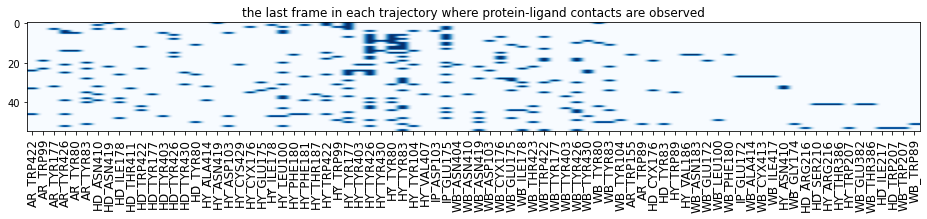

In [ ]:
def last_frames_by_contact(df_tot,columns_IFP,contacts=3):
    r_t_f = []
    com_tot = []
    diss = []
    for r in df_tot.Repl.unique():  
        df_repl = df_tot[df_tot.Repl == r]
        for t in df_repl.Traj.unique():
 #           print(r,t)
            df_traj = df_repl[df_repl.Traj == t]
            sum_IFP = df_traj[columns_IFP].sum(1).values
            last_frame = np.max(np.argwhere(sum_IFP > contacts))
            r_t_f.append((r,t,last_frame))
            
    df = pd.DataFrame(columns = df_tot.columns)        
    for (r,t,f) in r_t_f:  
        df_repl = df_tot[df_tot.Repl == r]
        df_traj = df_repl[df_repl.Traj == t]
        df = df.append(df_traj[df_traj.time == f], ignore_index = True)
        com_tot.append(df_traj[df_traj.time == f][["COM_x","COM_y","COM_z"]].values)
        diss.append(df_traj[df_traj.time == f]["length"].values)
    ar = df[columns_IFP].values
    return(ar,r_t_f,df,np.asarray(com_tot),np.asarray(diss))
     
ifp_list = ["AR","HD","HA","HY","WB","IP","IN"]
#ifp_list = ["RE"]
columns_IFP = []  # standard IFP
for c in df_tot.columns.tolist():
    if c[0:2] in ifp_list: columns_IFP.append(c)

#--------------- cluster by the last frame IFP
ar,r_t_f,df,com,time = last_frames_by_contact(df_tot,columns_IFP,4)
ar_nonzero = ar[:,(np.array(ar).sum(0) > 0)]  # remove empty columns
columns_IFP_nonzero = np.asarray(columns_IFP)[np.argwhere((np.array(ar).sum(0)>0)).flatten()]
#print(ar.shape,ar_nonzero.shape,ar_nonzero.sum(0),columns_IFP_nonzero)


fig = plt.figure(figsize = (16,2),facecolor='w')
plt.imshow(ar_nonzero.astype(float),cmap='Blues',aspect = "auto")
plt.xticks(range(0,len(columns_IFP_nonzero)),columns_IFP_nonzero,rotation=90,fontsize=12)
plt.title("the last frame in each trajectory where protein-ligand contacts are observed")
plt.plot()

**3.7.2 Clustering of egress routes**

Here hierarchical clustering is perfomed to identify the main egress routes. For each of them, residence times (ns) and populations (number of trajectories) are given.

1 44 ['AR_TRP422' 'AR_TRP99' 'AR_TYR177' 'AR_TYR426' 'AR_TYR80' 'AR_TYR83'
 'HD_ASN410' 'HD_ASN419' 'HD_ILE178' 'HD_TRP422' 'HD_TYR403' 'HD_TYR426'
 'HD_TYR430' 'HD_TYR80' 'HY_ASP103' 'HY_CYS429' 'HY_CYX176' 'HY_GLU175'
 'HY_ILE178' 'HY_LEU100' 'HY_TRP422' 'HY_TRP99' 'HY_TYR177' 'HY_TYR403'
 'HY_TYR426' 'HY_TYR430' 'HY_TYR80' 'HY_TYR83' 'HY_TYR104' 'IP_ASP103'
 'IP_GLU175' 'WB_ASN404' 'WB_ASN419' 'WB_ASP103' 'WB_CYX176' 'WB_GLU175'
 'WB_ILE178' 'WB_THR423' 'WB_TRP422' 'WB_TYR177' 'WB_TYR403' 'WB_TYR426'
 'WB_TYR430' 'WB_TYR80' 'WB_TYR83' 'WB_TYR104' 'AR_TRP89' 'HD_CYX176'
 'HD_TYR83' 'HY_TRP89' 'WB_GLU172' 'WB_LEU100' 'WB_GLY174' 'WB_TRP89']
1 ............... 44 [ 30.262   1.558   6.443  18.882   3.258  30.935   3.468  42.76   15.37
  12.282  12.494   5.603  30.552   2.885   8.541   5.933   6.455  39.231
 701.    701.    701.    701.    701.    700.    701.    701.      2.114
  33.111   6.806  11.886  17.276   8.623  20.765  20.004  30.215  47.317
  41.017  28.893   4.314  29.091  31.0

(array([1, 2, 3, 4, 5], dtype=int32), array([44,  8,  1,  1,  1]))

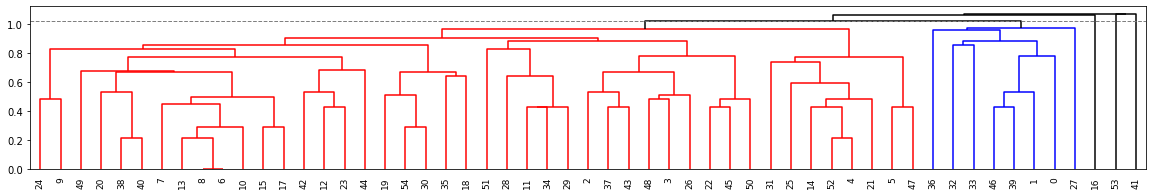

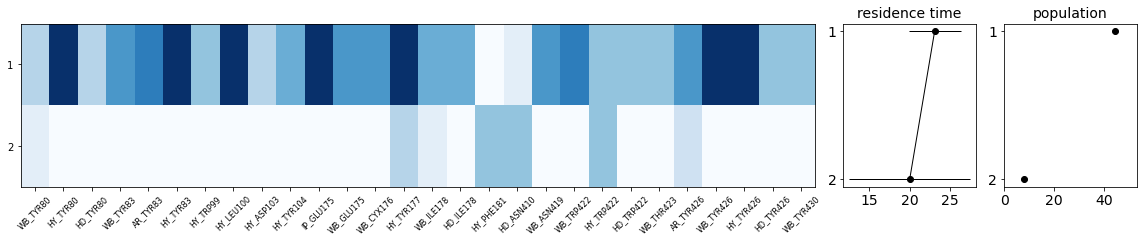

In [ ]:
from scipy.cluster import hierarchy
#######################
# estimation of the residence time for each cluster 
#
####################
def bootstrapp(t):
    max_shuffle = 500
    alpha = 0.9
    sub_set = int(alpha*len(t))        
    tau_bootstr = []
    if sub_set > 3: #( if the sub_set size is above 3, otherwise bootstrapping does not make sense)
        for i in range(1,max_shuffle):
            numpy.random.shuffle(t)
            t_b = t[:sub_set]
            t_b_sorted_50 = (np.sort(t_b)[int(len(t_b)/2.0-0.5)]+np.sort(t_b)[int(len(t_b)/2)])/2.0
            tau_bootstr.append(t_b_sorted_50)
    return(tau_bootstr)


X = ar_nonzero.astype(float)

Z= linkage(X, method = 'average', metric='correlation', optimal_ordering=True)
threshold =1.02

plt.figure(figsize=(20,3))
plt.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
hierarchy.set_link_color_palette(['r', 'b', 'orange', 'y', 'green', 'm','gray'])
den = dendrogram(Z, 0.25, color_threshold=threshold, above_threshold_color='k', leaf_font_size=9)

plt.savefig(DIR_out+"dendagram-ifp.png",dpi=300)    
 
clusters = clust.fcluster(Z,threshold, criterion='distance')

cl, count = np.unique(clusters,return_counts=True )
t_cluster = []
t_std_cluster = []
ifps_cluster = []
count_cluster = []
cl_cluster = []

# estimate residence time and population for each cluster 
for k,c in zip(cl,count):
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    ifps_mean = np.mean(X[ind,:],axis=0)
    print(k,c, columns_IFP_nonzero[np.argwhere(ifps_mean > 0)].flatten())
    if c > 1:
        print(k,"...............",c,time[ind].flatten())
        tb = np.asarray(bootstrapp(time[ind].flatten()))
        if (len(tb) > 0):
            t_cluster.append(np.mean(tb))
            t_std_cluster.append(np.std(tb))
        else:
            t_cluster.append(0)
            t_std_cluster.append(0)
        cl_cluster.append(k)
        count_cluster.append(c)
        ifps_cluster.append(np.sum(ar_nonzero.astype(float)[ind,:],axis=0))
        if(t_cluster[-1] > 0): print("Residence time:",k,c,t_cluster[-1])

# order clusters by the decrease of the  residence time           
count_cluster = np.array(count_cluster)
cl_cluster = np.array(cl_cluster)
t_cluster = np.array(t_cluster)
t_std_cluster = np.array(t_std_cluster)
index_tau = np.argsort(t_cluster)

#select IFP to show
index = []
for a in columns_IFP_nonzero:
    index.append(int(a[6:]))
index = np.argsort(index)
ifp_subset_large = (np.max(np.asarray(ifps_cluster)[index_tau][:,index],axis=0) > 2)

index = index[ifp_subset_large]
fig = plt.figure(figsize = (20,3),facecolor='w') 
gs = gridspec.GridSpec(1,3, width_ratios=[6, 1,1],wspace=0.08) 


ax = plt.subplot(gs[0])
ax.imshow(np.asarray(ifps_cluster)[np.flip(index_tau)][:,index],cmap='Blues',aspect = "auto",vmin=0, vmax=10)
plt.yticks(range(0,cl_cluster[np.flip(index_tau)].shape[0]),cl_cluster[np.flip(index_tau)],fontsize=10)
plt.xticks(range(0,len(columns_IFP_nonzero[index])),columns_IFP_nonzero[index],rotation=45,fontsize=8)
#---------- plot residence times in clusters
ax = plt.subplot(gs[1])
ax.errorbar(y=range(0,len(t_cluster[index_tau])),x=t_cluster[index_tau],xerr=t_std_cluster[index_tau],color = 'k', marker='o',lw=1)
plt.yticks(range(0,len(cl_cluster[index_tau])),cl_cluster[index_tau],fontsize=14)
#plt.xlim((0.2,1.2*max(t_cluster)))
plt.xticks(fontsize=14)
plt.title("residence time",fontsize=14)
print("res.times ",t_cluster)
#plt.ylim((1,len(t_cluster)+1))
#--------------- plot cluster population
ax = plt.subplot(gs[2])
ax.scatter(y=range(0,len(t_cluster[index_tau])),x=count_cluster[index_tau],color = 'k')
#plt.yticks(range(0,np.max(cl_cluster)),np.flip(cl_cluster),fontsize=14)
plt.yticks(range(0,len(cl_cluster[index_tau])),cl_cluster[index_tau],fontsize=14)
plt.xticks(fontsize=14)
plt.xlim((0,1.2*np.max(count_cluster)))
plt.title("population",fontsize=14)
#plt.ylim((1,np.max(cl)))
plt.savefig(DIR_out+"clusters-ifp.png",dpi=300,bbox_inches = 'tight')    

print("Res.times:", t_cluster,"re-ordered:",t_cluster[index_tau])
print("Population:", count_cluster,"re-ordered:",count_cluster[index_tau])
cl, count

**3.7.3 Visualization of engress routes on 3D grid**

With the following cell, a ligand COM distribution for each cluster is generated by summing over all the snapshots assigned to the cluster.

These files will be saved in `DIR_out` accessible from the 'File' icon on the left. If uploaded in Pymol together with the reference pdb, they can be displayed using the following command line:

*e.g.*, for egress route 1:

 `isosurface egress1, densityFV1--10-f12_1, 1, 4MQT-IXO-PAM,`

 Note: The reference PDB files can be found in `pdbdir`


In [ ]:
print("Cluster numbers:",cl)
print("Cluster populations:",count)
for k in cl[count>1]:
    print("save cluster ",k)
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    channel = np.asarray(r_t_f)[ind]
    for i,ch in enumerate(channel):
        d = df_tot[(df_tot.Repl == ch[0]) & (df_tot.Traj == ch[1])] # & (df_tot.time == int(ch[2]))]
        if i == 0: d_channel = d
        else: d_channel = pd.concat([d_channel,d])
    if(i > 1):
        #print(channel)
        Map_3D_grid( d_channel,DIR_out+"densityFV1-"+"-"+str(int(threshold*10))+"-"+version+str(k)+".dx")

Cluster numbers: [1 2 3 4 5]
Cluster populations: [44  8  1  1  1]
save cluster  1
save cluster  2
